In [1]:
!pip install tensorflow

In [137]:
!pip install tensorflow-io

In [36]:
import sys
import os
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import matplotlib.pyplot as plt
import re

In [37]:
data_paths = []
#audio_labels = []
label_tags = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'go', 'on', 'off', 'stop']

In [38]:
for directory, subdirectories, files in os.walk("../../../Data/"):

    phn_dir = ""
    wav_dir = ""
    prompts_dir = ""

    for subdirectory in subdirectories:

        if subdirectory.startswith("phn_"):
            phn_dir = os.path.join(directory, subdirectory)

        elif phn_dir and subdirectory.startswith("wav_"):
            if (phn_dir.endswith("headMic") and subdirectory.endswith("headMic")) or (phn_dir.endswith("arrayMic") and subdirectory.endswith("arrayMic")):
                wav_dir = os.path.join(directory, subdirectory)

        elif subdirectory.startswith("prompts"):
            prompts_dir = os.path.join(directory, subdirectory)

    if phn_dir and wav_dir and prompts_dir:
        data_paths.append((phn_dir, wav_dir, prompts_dir))

valid_data = []
for paths in data_paths:
    for filename in os.listdir(paths[2]):
        with open(os.path.join(paths[2], filename)) as f:
            prompt = f.readline().rstrip().lower()
            if prompt not in label_tags:
                continue
        phn_fullpath = os.path.join(paths[0], os.path.splitext(os.path.basename(filename))[0] + ".phn")
        if not os.path.exists(phn_fullpath):
            print("Matching phoneme file not found for {}".format(filename))
            continue
        lines = []
        with open(phn_fullpath) as f:
            lines = f.read().splitlines()

        if len(lines) < 2:
            continue 

        wav_fullpath = os.path.join(paths[1], os.path.splitext(os.path.basename(filename))[0] + ".wav")

        if not os.path.exists(wav_fullpath):
            continue

        valid_data.append(wav_fullpath)


Matching phoneme file not found for 0082.txt
Matching phoneme file not found for 0144.txt
Matching phoneme file not found for 0156.txt
Matching phoneme file not found for 0172.txt
Matching phoneme file not found for 0184.txt
Matching phoneme file not found for 0185.txt
Matching phoneme file not found for 0199.txt
Matching phoneme file not found for 0220.txt
Matching phoneme file not found for 0038.txt
Matching phoneme file not found for 0039.txt
Matching phoneme file not found for 0049.txt
Matching phoneme file not found for 0058.txt
Matching phoneme file not found for 0074.txt
Matching phoneme file not found for 0080.txt
Matching phoneme file not found for 0107.txt
Matching phoneme file not found for 0118.txt
Matching phoneme file not found for 0124.txt
Matching phoneme file not found for 0108.txt


In [39]:
def get_label(path):
    #tf.strings.split()
    path_parts = re.split('.\\/', path)
    prompt_number = path_parts[-2]
    prompt_path = os.path.join(path_parts[0:-3], "prompts", prompt_number + ".txt")

    with open(prompt_path) as f:
        prompt = f.readline().rstrip().lower()
        return prompt

In [40]:
def cut_audio(path, audio):
    path_parts = re.split('.\\/', path)
    phoneme_number = path_parts[-2]
    phoneme_type = path_parts[-3].split("_")[1]
    phoneme_folder = "phn_" + phoneme_type

    phoneme_path = os.path.join(path_parts[0:-3], phoneme_folder, prompt_number + ".txt")

    lines = []
    with open(phoneme_path) as f:
        lines = f.read().splitlines()

    wav_start = int(lines[1].rstrip().split(" ")[0])
    wav_end = int(lines[-1].rstrip().split(" ")[1])
    return audio[wav_start:wav_end]

In [41]:
def read_audio(path):
    wav_binary = tf.io.read_file(wav_fullpath)
    audio, _ = tf.audio.decode_wav(wav_binary)
    audio = cut_audio(path, audio)
    return audio

In [54]:
def get_waveform_and_label(path):
    label = tf.convert_to_tensor(get_label(path), dtype=tf.string)
    audio = read_audio(path)
    return (audio, label)

In [55]:
filenames = tf.convert_to_tensor(valid_data, dtype=tf.string)
filenames = tf.random.shuffle(filenames)

train_files = filenames[0:100]
val_files = filenames[100:113]
test_files = filenames[113:125]

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


AttributeError: in user code:

    <ipython-input-54-71b454091c4c>:2 get_waveform_and_label  *
        path = path.numpy()

    AttributeError: 'Tensor' object has no attribute 'numpy'


In [56]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

tf.Tensor(b'../../../Data/A_M\\M04\\Session2\\wav_headMic\\0015.wav', shape=(), dtype=string)


InvalidArgumentError: TypeError: cannot use a string pattern on a bytes-like object
Traceback (most recent call last):

  File "C:\Users\Nana7\Anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "C:\Users\Nana7\Anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "C:\Users\Nana7\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-51-93bcc33b1885>", line 3, in get_waveform_and_label
    label = tf.convert_to_tensor(get_label(path), dtype=tf.string)

  File "<ipython-input-39-caac214b0119>", line 2, in get_label
    path_parts = re.split('.\\/', path)

  File "C:\Users\Nana7\Anaconda3\lib\re.py", line 213, in split
    return _compile(pattern, flags).split(string, maxsplit)

TypeError: cannot use a string pattern on a bytes-like object


	 [[{{node EagerPyFunc}}]]

In [199]:
files_ds = tf.data.Dataset.from_tensor_slices(data_paths)


for paths in data_paths:
    valid_inputs = []
    for filename in os.listdir(paths[2]):
        with open(os.path.join(paths[2], filename)) as f:
            prompt = f.readline().rstrip().lower()
            if prompt in label_tags:
                valid_inputs.append((os.path.splitext(os.path.basename(filename))[0], prompt))

    valid_timestamps = []
    for valid_input in valid_inputs:
        wav_start = 10000000000
        wav_end = 0
        phn_fullpath = os.path.join(paths[0], valid_input[0] + ".phn")
        if not os.path.exists(phn_fullpath):
            print("Matching phoneme file not found for {}".format(valid_input))
            continue
        lines = []
        with open(phn_fullpath) as f:
            lines = f.read().splitlines()

        if len(lines) < 2:
            continue

        wav_start = int(lines[1].rstrip().split(" ")[0])
        wav_end = int(lines[-1].rstrip().split(" ")[1])
        valid_timestamps.append((*valid_input, wav_start, wav_end))
    
    for valid_timestamp in valid_timestamps:
        wav_fullpath = os.path.join(paths[1], valid_timestamp[0] + ".wav")
        if not os.path.exists(wav_fullpath):
            print("Matching WAV file not found for {}".format(valid_input))
            continue
        wav_binary = tf.io.read_file(wav_fullpath)
        audio, _ = tf.audio.decode_wav(wav_binary)
        audio = audio[valid_timestamp[2]:valid_timestamp[3]]
        audio_labels.append((audio, valid_timestamp[1]))

Matching phoneme file not found for ('0082', 'yes')
Matching phoneme file not found for ('0144', 'eight')
Matching phoneme file not found for ('0156', 'yes')
Matching phoneme file not found for ('0172', 'nine')
Matching phoneme file not found for ('0184', 'zero')
Matching phoneme file not found for ('0185', 'seven')
Matching phoneme file not found for ('0199', 'six')
Matching phoneme file not found for ('0220', 'no')
Matching phoneme file not found for ('0038', 'one')
Matching phoneme file not found for ('0039', 'up')
Matching phoneme file not found for ('0049', 'right')
Matching phoneme file not found for ('0058', 'go')
Matching phoneme file not found for ('0074', 'left')
Matching phoneme file not found for ('0080', 'down')
Matching phoneme file not found for ('0107', 'two')
Matching phoneme file not found for ('0118', 'yes')
Matching phoneme file not found for ('0124', 'no')
Matching phoneme file not found for ('0108', 'yes')


49320


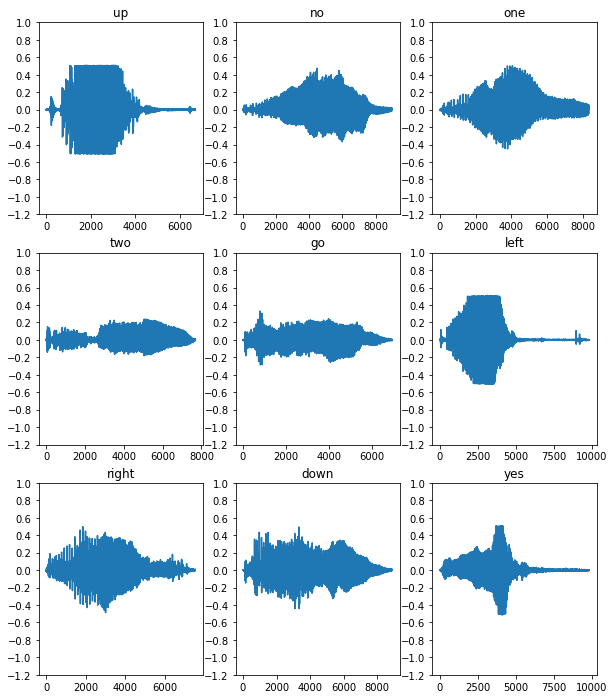

In [200]:
#print(audio_labels)
max_samples = 0
for audio, label in audio_labels:
  max_samples = max(max_samples, np.shape(audio)[0])

print(max_samples)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(audio_labels[0:n]):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio)
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.set_title(label)

plt.show()

In [201]:
def get_spectrogram(waveform):
    # Padding
    waveform = tf.squeeze(waveform)
    if tf.shape(waveform)[0] < 32000:
        zero_padding = tf.zeros([32000] - tf.shape(waveform), dtype=tf.float32)

        # Concat audio w/ padding to the same length
        waveform = tf.cast(waveform, tf.float32)
        equal_length = tf.concat([waveform, zero_padding], 0)
    
    else:
        waveform = tf.cast(waveform, tf.float32)
        equal_length = waveform[0:32000]
    #spectrogram = tf.signal.stft(equal_length, frame_length = 255, frame_step=256)
    spectrogram = tfio.experimental.audio.spectrogram(equal_length, nfft=512, window=128, stride=128)

    #spectrogram = tf.abs(spectrogram)

    return spectrogram

In [202]:
for waveform, label in audio_labels:
    waveform = tf.squeeze(waveform)
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
#print('Audio playback')
#display.display(display.Audio(waveform, rate=16000))

Label: one
Waveform shape: (19560,)
Spectrogram shape: (250, 257)


"\n  # Convert to frequencies to log scale and transpose so that the time is\n  # represented in the x-axis (columns).\n  log_spec = np.log(spectrogram.T)\n  height = log_spec.shape[0]\n  X = np.arange(32000, step=height + 1)\n  Y = range(height)\n  ax.pcolormesh(X, Y, log_spec)\n\n\nfig, axes = plt.subplots(2, figsize=(12, 8))\ntimescale = np.arange(waveform.shape[0])\naxes[0].plot(timescale, waveform.numpy())\naxes[0].set_title('Waveform')\naxes[0].set_xlim([0, 32000])\nplot_spectrogram(spectrogram.numpy(), axes[1])\naxes[1].set_title('Spectrogram')\nplt.show()\n"

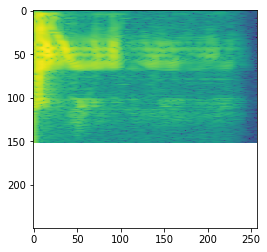

In [203]:
def plot_spectrogram(spectrogram, ax):
    ax.imshow(tf.math.log(spectrogram).numpy())

fig, ax = plt.subplots()
plot_spectrogram(spectrogram, ax)

In [240]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.constant(label_tags.index(label), dtype=tf.int32)
  return spectrogram, label_id



In [241]:
spectrograms = [get_spectrogram_and_label_id(audio, label) for audio, label in audio_labels]


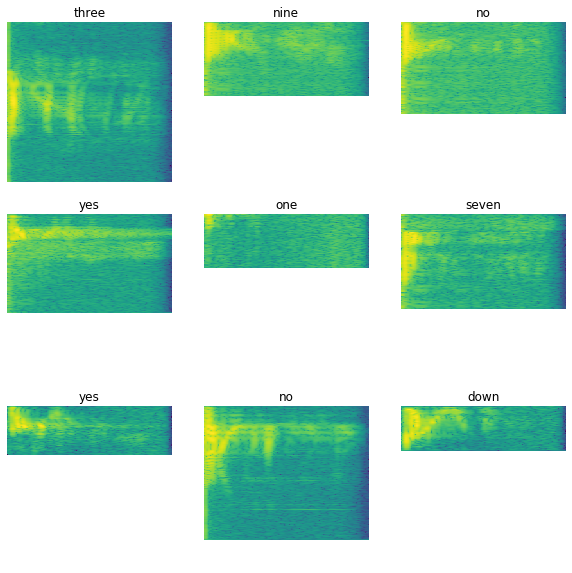

In [244]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrograms[100:100+n]):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(label_tags[label_id])
  ax.axis('off')

plt.show()

In [246]:
import random
random.shuffle(spectrograms)
print(spectrograms)
train_set = tf.data.Dataset.from_tensor_slices(spectrograms[0:100])
val_set = tf.data.Dataset.from_tensor_slices(spectrograms[100:113])
test_set = tf.data.Dataset.from_tensor_slices(spectrograms[113:125])

4487e-05]],

       ...,

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int32, numpy=14>), (<tf.Tensor: shape=(250, 257, 1), dtype=float32, numpy=
array([[[6.2766820e-02],
        [6.5837204e-02],
        [7.1126349e-02],
        ...,
        [1.7583385e-05],
        [2.1370139e-05],
        [2.2869557e-05]],

       [[2.9580194e-01],
        [2.9305211e-01],
        [2.8353256e-01],
        ...,
        [5.0014241e-05],
        [6.0895680e-05],
        [6.4298511e-05]],

       [[3.9131516e-01],
    

InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Pack] name: 0